# Covid-19: From model prediction to model predictive control

Code by T.W. Alleman
in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
import coronaHelper as cH
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

## Het uitgebreide SEIR-ziektemodel

In deze Jupyter Notebooks werd een uitbreiding van het SEIR (Susceptible - Exposed - Infected - Removed) ziektemodel geimplementeerd. Het gaat om een simpel en geidealiseerd model dat desondanks toch vaak wordt toegepast in onderzoek (). De dynamica van het geimplementeerde model wordt op onderstaande flowchart rechts weergegeven terwijl het SEIR model links wordt weergegeven,

<img src="flowchart.jpg"
     alt="flowchart"
     height="180" width="800"     
     style="float: middle; margin-right: 500px;" />  

Deze uitbreiding van het SEIR model heeft een hogere resolutie door de zieken onder te verdelen in supermilde, milde, zware en kritieke gevallen. Wanneer deze vier categorien worden opgeteld wordt opnieuw de voorspelling van het normale SEIR bekomen. De volgende assumpties worden gemaakt: alle doden komen uit hospitaals en alleen patienten in kritieke toestand gaan dood. Supermilde, milde en zware gevallen leiden tot immuniteit en in geen enkel geval de dood. Zowel een besmet persoon als een (super)mild ziek persoon kunnen onderhevigen besmetten. Alle besmettingsdata is afkomstig van de world-o-meter website. De besmettingsdata wordt geinterpreteerd als de som van alle mild, zwaar en kritiek zieken. Voor de zware en kritieke gevallen is dit een goede benadering, in deze gevallen is het duidelijk dat het om Covid-19 gaat. In praktijk zal echter een fractie van de mild zieken ook onder de radar blijven. Dit zorgt ervoor dat de verkregen resultaten een onderschatting zijn van het werkelijke aantal zieken en besmetten. Uit een recente publicatie van Chinese wetenschappers (16/03) blijkt dat 86% van de infecties in China onder de radar bleven voor de reisrestricties van 23 januari. We nemen aan dat alle supermild zieken onder de radar de blijven, bijgevolg is de kans op een supermild ziekteverloop 86%. In dit model wordt rekening gehouden met de onzerheid op de incubatieperiode d.m.v. een Monte-Carlo simulatie. De distributiefunctie van de incubatieperioden is gebaseerd op data van de Covid-19 uitbraak in China en wordt hieronder weergegeven.

<img src="incubatieperiode.png"
     alt="incubatieperiode"
     height="180" width="400"     
     style="float: middle; margin-right: 500px;" />  
     
De dynamica van het systeem wordt gegeven door volgende differentiaalvergelijkingen,

$$\frac{dO}{dt} = - \beta \cdot O \cdot \Big( \frac{B+M+SM}{T} \Big),$$

$$\frac{dB}{dt} = \beta \cdot O \cdot \Big( \frac{B+M+SM}{T} \Big) - \beta / \gamma,$$

$$\frac{dSM}{dt} =  sm \cdot B / \gamma - SM / d_{sm}, $$

$$\frac{dM}{dt} =  m \cdot B / \gamma - M / d_m, $$

$$\frac{dZ}{dt} =  z \cdot B / \gamma - Z / d_z, $$

$$\frac{dH}{dt} =  h \cdot B / \gamma - H / d_h, $$

$$\frac{dI}{dt} =  \frac{SM}{d_{sm}} + \frac{M}{d_m} + \frac{Z}{d_z} + (1-m_h) \cdot H / d_h,$$

$$\frac{dD}{dt} =  m_h \cdot H / d_h,$$

$$\frac{dT}{dt} =  - m_h \cdot H / d_h,$$

hier stelt O de onderhevigen, B de besmetten, SM de supermild zieken, M de mild zieken, Z de zwaar zieken, H de hevig zieken, I de immunen, D de doden en T de totale bevolking voor. De parameters zijn: de incubatieperiode in dagen ($\gamma$), het aantal ziektedagen bij een supermild, mild, zwaar en kritiek verloop van Covid-19  ($d_{sm}$, $d_m$, $d_z$, $d_h$), de kans op een supermild, mild, zwaar of kritiek ziekteverloop (sm,m,z,h), de mortaliteit bij een kritiek verloop ($m_h$). De focus van dit werk ligt op de invloed van de hoeveelheid sociale interactie op de verspreiding van het virus. Deze wordt gecontroleerd door de parameter $\beta$, echter, eerst moet worden bepaald wat de nominale waarden van $\beta$ zijn in verschillende situaties gaande van een quarantaine tot een business-as-usual.

### Compensatie van onderschatting op aantal besmetten

Uit een recente publicatie van Chinese wetenschappers (16/03) blijkt dat 86% van de infecties in China onder de radar bleven voor de reisrestricties van 23 januari. We nemen hierdoor aan dat,

$$ sm = 0.86, $$

$$ m = (1-0.86)\cdot 0.809 = 0.1133, $$

$$ h = (1-0.86)\cdot 0.138 = 0.0193, $$

$$ z = (1-0.86)\cdot 0.0.047 = 0.0066, $$ 

en nemen aan dat het totaal aantal gerapporteerde cases gelijk is aan de som van alle mild, zwaar en kritiek zieken. De supermild zieken blijven onder de radar.

### Constante parameters

In [2]:
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
sm = 0.86
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop

# Calibratie $\beta$  m.b.h.v. data van buurlanden

## Landen met een zwakke overheidsrespons
Doel: bepalen van de waarde van $\beta$ in afwezigheid van enige actie.

In [3]:
betaZonderIngrijpen=[]

### Italie

#### Ingeven data
Een complete lockdown is van toepassing in Italie sinds 8 maart 2020. Door de incubatieperiode kan data tot 15 maart 2020 gebruikt worden onder de assumptie dat er geen overheidsingrijpen was.

In [4]:
infected = np.array([[3,3,3,3,3,4,19,75,152,221,310,455,593,822,1049,1577,1835,2263,2706,3296,3916,5061,6387,7985,8514,10590,12839,14955,17750,20603,23073,26062,28710,33190,37860]])
index=pd.date_range('2020-02-15', freq='D', periods=infected.size)
columns = ['infected','dead']
dead = np.array([[0,0,0,0,0,0,1,2,3,7,11,12,17,21,29,41,52,79,107,148,197,233,366,463,631,827,1016,1266,1441,1809,2158,2503,2978,3405,4032]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_italie=pd.DataFrame(data,index=index, columns=columns)

#### Uitvoeren fit

Data gefit van 2020-02-15 tot 2020-03-15.

In [5]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  60.48e06 # Italiaanse populatie
ICU = 5090 # estimated number of ICU beds in country

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=50
popsize=5
polish=True
disp = True
bounds=[(0.2,0.4),(1,100000)]
data=np.transpose(infected[:,0:-5])
#data=np.transpose(dead[:,0:-5]) don't forget to uncomment when fitting to the dead
method = 'findInfected'
fitTo = np.array([5,6]) #positions in output of runSimulation that must be added together 

# -------------------
# Methods for fitting
# -------------------
#'findTime': uses an initial condition of one infected person and finds the additional time that must be
# simulated to match the number of infected at the beginning of data recording
#'findGovernmentResponse': simulates a step change in policy at fitted value 'measureTime', starts from one infected as initial condition
#'findInfected': finds the number of B (exposed) at the beginning of data recording 

# ---------------
# General methods
# ---------------
#'variableBeta': simulates the model by using a vector of beta (one beta/day) as its input
#'none': plain model simulation 

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 4.76419e+08
differential_evolution step 2: f(x)= 1.84612e+08
differential_evolution step 3: f(x)= 1.84612e+08
differential_evolution step 4: f(x)= 1.84612e+08
differential_evolution step 5: f(x)= 1.84612e+08
differential_evolution step 6: f(x)= 1.84612e+08
differential_evolution step 7: f(x)= 1.84612e+08
differential_evolution step 8: f(x)= 7.2933e+07
differential_evolution step 9: f(x)= 7.2933e+07
differential_evolution step 10: f(x)= 3.96069e+07
differential_evolution step 11: f(x)= 3.96069e+07
differential_evolution step 12: f(x)= 3.96069e+07
differential_evolution step 13: f(x)= 2.01204e+07
differential_evolution step 14: f(x)= 1.50142e+07
differential_evolution step 15: f(x)= 9.42734e+06
differential_evolution step 16: f(x)= 9.42734e+06
differential_evolution step 17: f(x)= 9.42734e+06
differential_evolution step 18: f(x)= 9.42734e+06
differential_evolution step 19: f(x)= 9.42734e+06
differential_evolution step 20: f(x)= 6.1431e+06
differential

#### Plotten fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

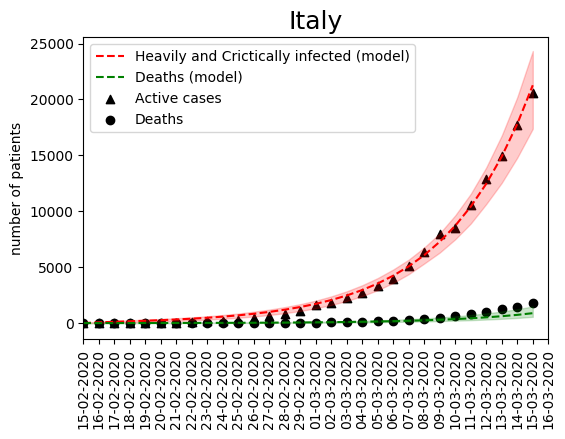

In [6]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
B0 = estimate[1]
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
simtime=data.size-1
tN=simtime + 1
method = 'none'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index[0:-5]),data_italie.iloc[0:-5,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index[0:-5]),data_italie.iloc[0:-5,1],color="black",marker="o")
plt.plot(pd.to_datetime(index[0:-5]),np.mean(som,axis=1),'--',color="red")
plt.fill_between(pd.to_datetime(index[0:-5]),np.percentile(som,95,axis=1),
                 np.percentile(som,5,axis=1),color="red",alpha=0.2)
plt.plot(pd.to_datetime(index[0:-5]),np.mean(D,axis=1),'--',color="green")
plt.fill_between(pd.to_datetime(index[0:-5]),np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-5]))
plt.title('Italy',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Frankrijk

#### Ingeven data

In [7]:
infected = np.array([[7,7,6,4,4,4,4,1,1,0,2,5,25,44,86,116,176,196,269,404,632,921,1178,1370,1739,2221,2803,3570,4396,5284,6473,6953,8268,9328,10575]])
index=pd.date_range('2020-02-15', freq='D', periods=infected.size)
columns = ['infected','dead']
dead = np.array([[1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,4,4,7,9,16,19,30,33,48,61,79,91,127,148,175,264,372,450]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_frankrijk=pd.DataFrame(data,index=index, columns=columns)

#### Uitvoeren fit
Data gefit van 2020-02-15 tot 2020-03-19.

In [8]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
ICU = 5000
T0 =  66.89e06 # Franse populatie

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=50
popsize=5
polish=True
disp = True
bounds=[(0.15,0.4),(1,100000)]
data=np.transpose(infected[:,0:-1])
method = 'findInfected'
fitTo = np.array([5,6]) #positions in output of runSimulation that must be added together 

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 3.29479e+08
differential_evolution step 2: f(x)= 3.29479e+08
differential_evolution step 3: f(x)= 2.48534e+07
differential_evolution step 4: f(x)= 2.48534e+07
differential_evolution step 5: f(x)= 1.50682e+07
differential_evolution step 6: f(x)= 1.50682e+07
differential_evolution step 7: f(x)= 1.39246e+07
differential_evolution step 8: f(x)= 1.39246e+07
differential_evolution step 9: f(x)= 1.39246e+07
differential_evolution step 10: f(x)= 1.39246e+07
differential_evolution step 11: f(x)= 7.67755e+06
differential_evolution step 12: f(x)= 7.67755e+06
differential_evolution step 13: f(x)= 7.67755e+06
differential_evolution step 14: f(x)= 5.3774e+06
differential_evolution step 15: f(x)= 5.3774e+06
differential_evolution step 16: f(x)= 5.27179e+06
differential_evolution step 17: f(x)= 5.05775e+06
differential_evolution step 18: f(x)= 4.92104e+06
differential_evolution step 19: f(x)= 4.90785e+06
differential_evolution step 20: f(x)= 4.82758e+06
differentia

#### Plotten fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

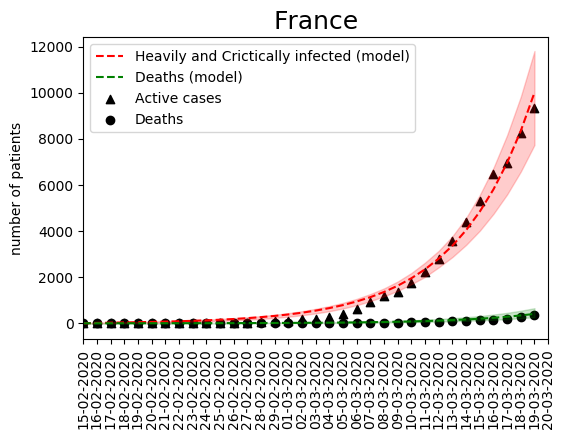

In [9]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
B0 = estimate[1]
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
simtime=data.size-1
tN=simtime + 1
method = 'none'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index[0:-1]),data_frankrijk.iloc[0:-1,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index[0:-1]),data_frankrijk.iloc[0:-1,1],color="black",marker="o")
plt.plot(pd.to_datetime(index[0:-1]),np.mean(som,axis=1),'--',color="red")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(som,95,axis=1),
                 np.percentile(som,5,axis=1),color="red",alpha=0.2)
plt.plot(pd.to_datetime(index[0:-1]),np.mean(D,axis=1),'--',color="green")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('France',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Spanje
#### Ingeven van de data

In [10]:
columns = ['infected','dead']
infected = np.array([[0,0,0,0,0,0,0,0,0,1,7,11,23,31,56,82,118,162,224,276,387,485,625,1169,1524,2039,2871,4906,5678,7177,9070,10265,13050,16139,18890]])
index=pd.date_range('2020-02-15', freq='D', periods=infected.size)
dead = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,8,10,17,30,36,55,86,133,196,294,342,533,638,831,1093]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_spanje=pd.DataFrame(data,index=index, columns=columns)

#### Uitvoeren fit
Data gefit van 2020-02-15 tot 2020-03-19.

In [11]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  46.66e06 # Spaanse populatie
ICU = 4404

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=50
popsize=5
polish=True
disp = True
bounds=[(0.15,0.4),(1,100000)]
data=np.transpose(infected[:,0:-1])
method = 'findInfected'
fitTo = np.array([5,6]) #positions in output of runSimulation that must be added together 

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 7.68619e+07
differential_evolution step 2: f(x)= 7.68619e+07
differential_evolution step 3: f(x)= 7.68619e+07
differential_evolution step 4: f(x)= 6.509e+07
differential_evolution step 5: f(x)= 6.509e+07
differential_evolution step 6: f(x)= 6.509e+07
differential_evolution step 7: f(x)= 6.509e+07
differential_evolution step 8: f(x)= 3.35575e+07
differential_evolution step 9: f(x)= 3.35575e+07
differential_evolution step 10: f(x)= 3.35575e+07
differential_evolution step 11: f(x)= 2.14023e+07
differential_evolution step 12: f(x)= 2.14023e+07
differential_evolution step 13: f(x)= 2.14023e+07
differential_evolution step 14: f(x)= 2.14023e+07
differential_evolution step 15: f(x)= 1.37326e+07
differential_evolution step 16: f(x)= 1.37326e+07
differential_evolution step 17: f(x)= 8.44147e+06
differential_evolution step 18: f(x)= 7.69421e+06
differential_evolution step 19: f(x)= 7.69421e+06
differential_evolution step 20: f(x)= 7.51927e+06
differential_evol

#### Plotten fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

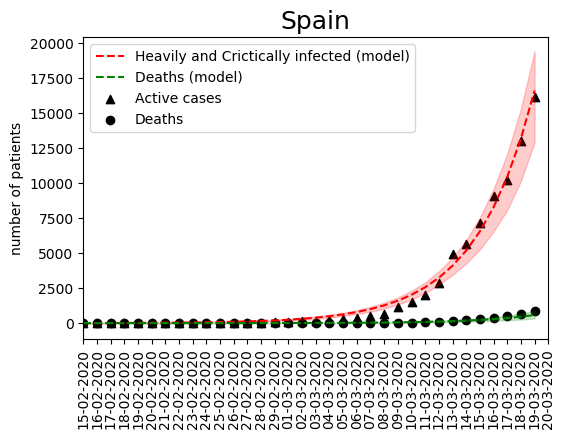

In [12]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
B0 = estimate[1]
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
simtime=data.size-1
tN=simtime + 1
method = 'none'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]
    
# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index[0:-1]),data_spanje.iloc[0:-1,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index[0:-1]),data_spanje.iloc[0:-1,1],color="black",marker="o")
plt.plot(pd.to_datetime(index[0:-1]),np.mean(som,axis=1),'--',color="red")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(som,95,axis=1),
                 np.percentile(som,5,axis=1),color="red",alpha=0.2)
plt.plot(pd.to_datetime(index[0:-1]),np.mean(D,axis=1),'--',color="green")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('Spain',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Duitsland

Op 20/03 nog stees niet in lockdown!

#### Ingeven van de data

In [13]:
columns = ['infected','dead']
infected = np.array([[13,13,9,7,7,3,2,2,2,2,3,11,32,58,63,114,149,187,246,528,652,782,1022,1204,1545,1938,2714,3621,4544,5754,7188,9274,12194,15161,19600]])
index=pd.date_range('2020-02-15', freq='D', periods=infected.size)
dead = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,6,8,9,13,17,26,28,44,68]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_duitsland=pd.DataFrame(data,index=index, columns=columns)

##### Uitvoeren fit
Data gefit van 2020-02-15 tot 2020-03-19.

In [14]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  82.79e06 # Duitse populatie
ICU = 28000

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=50
popsize=5
polish=True
disp = True
bounds=[(0.15,0.4),(1,100000)]
data=np.transpose(infected[:,0:-1])
method = 'findInfected'
fitTo = np.array([5,6]) #positions in output of runSimulation that must be added together 

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 9.11768e+07
differential_evolution step 2: f(x)= 9.11768e+07
differential_evolution step 3: f(x)= 9.11768e+07
differential_evolution step 4: f(x)= 9.11768e+07
differential_evolution step 5: f(x)= 8.55531e+07
differential_evolution step 6: f(x)= 7.00232e+07
differential_evolution step 7: f(x)= 5.34742e+07
differential_evolution step 8: f(x)= 5.34742e+07
differential_evolution step 9: f(x)= 5.34742e+07
differential_evolution step 10: f(x)= 4.65626e+07
differential_evolution step 11: f(x)= 4.34378e+07
differential_evolution step 12: f(x)= 4.34035e+07
differential_evolution step 13: f(x)= 2.67826e+07
differential_evolution step 14: f(x)= 2.16983e+07
differential_evolution step 15: f(x)= 1.99272e+07
differential_evolution step 16: f(x)= 1.99272e+07
differential_evolution step 17: f(x)= 1.93581e+07
differential_evolution step 18: f(x)= 1.93581e+07
differential_evolution step 19: f(x)= 1.85165e+07
differential_evolution step 20: f(x)= 1.85165e+07
different

#### Plot fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

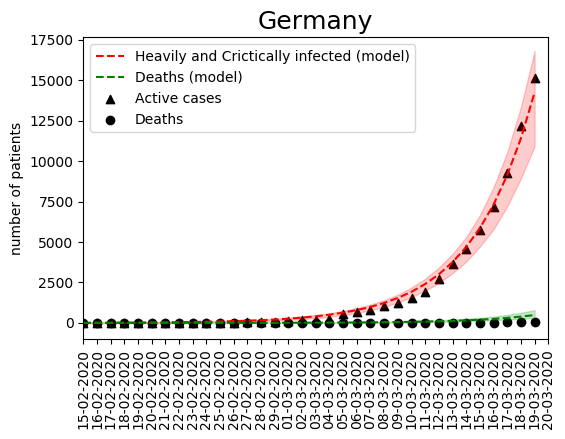

In [15]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
B0 = estimate[1]
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
simtime=data.size-1
tN=simtime + 1
method = 'none'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index[0:-1]),data_duitsland.iloc[0:-1,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index[0:-1]),data_duitsland.iloc[0:-1,1],color="black",marker="o")
plt.plot(pd.to_datetime(index[0:-1]),np.mean(som,axis=1),'--',color="red")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(som,95,axis=1),
                 np.percentile(som,5,axis=1),color="red",alpha=0.2)
plt.plot(pd.to_datetime(index[0:-1]),np.mean(D,axis=1),'--',color="green")
plt.fill_between(pd.to_datetime(index[0:-1]),np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('Germany',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Belgie
#### Ingeven data

In [33]:
columns = ['infected','dead']
infected=np.array([[0,0,0,0,0,0,0,0,0,0,1,7,12,22,49,108,168,199,238,266,310,395,555,684,886,1085,1243,1486,1795,2257,2815]])
index=pd.date_range('2020-02-20', freq='D', periods=infected.size)
dead = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,4,4,5,10,14,21,37,67]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_belgie=pd.DataFrame(data,index=index, columns=columns)
#bron: https://www.tijd.be/dossiers/coronavirus/116-558-besmettingen-het-coronavirus-in-kaart/10210378.html
#https://www.standaard.be/cnt/dmf20200320_04896529

#### Uitvoeren fit
Data gefit van 2020-02-15 tot 2020-03-20.

In [16]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 #  Vlaamse populatie
ICU = 1900

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=50
popsize=5
polish=True
disp = True
bounds=[(0.15,0.4),(1,100000)]
data=np.transpose(infected[:,0:-2])
method = 'findInfected'
fitTo = np.array([5,6]) #positions in output of runSimulation that must be added together 

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 6.47897e+07
differential_evolution step 2: f(x)= 6.47897e+07
differential_evolution step 3: f(x)= 6.47897e+07
differential_evolution step 4: f(x)= 4.82716e+07
differential_evolution step 5: f(x)= 4.82716e+07
differential_evolution step 6: f(x)= 3.42195e+07
differential_evolution step 7: f(x)= 3.42195e+07
differential_evolution step 8: f(x)= 2.38388e+07
differential_evolution step 9: f(x)= 2.23422e+07
differential_evolution step 10: f(x)= 2.23422e+07
differential_evolution step 11: f(x)= 2.09943e+07
differential_evolution step 12: f(x)= 2.09943e+07
differential_evolution step 13: f(x)= 1.85896e+07
differential_evolution step 14: f(x)= 1.58674e+07
differential_evolution step 15: f(x)= 1.23204e+07
differential_evolution step 16: f(x)= 1.12674e+07
differential_evolution step 17: f(x)= 1.1046e+07
differential_evolution step 18: f(x)= 1.1046e+07
differential_evolution step 19: f(x)= 1.09189e+07
differential_evolution step 20: f(x)= 9.10398e+06
differentia

#### Plotten fit

In [17]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
B0 = estimate[1]
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
simtime=data.size-1
tN=simtime + 1
method = 'none'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index[0:-2]),data_belgie.iloc[0:-2,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index[0:-2]),data_belgie.iloc[0:-2,1],color="black",marker="o")
plt.plot(pd.to_datetime(index[0:-2]),np.mean(som,axis=1),'--',color="red")
plt.fill_between(pd.to_datetime(index[0:-2]),np.percentile(som,95,axis=1),
                 np.percentile(som,5,axis=1),color="red",alpha=0.2)
plt.plot(pd.to_datetime(index[0:-2]),np.mean(D,axis=1),'--',color="green")
plt.fill_between(pd.to_datetime(index[0:-2]),np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

NameError: name 'data_belgie' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 600x400 with 0 Axes>

### Conclusie

In [ ]:
gem = np.mean(betaZonderIngrijpen)
sd = np.std(betaZonderIngrijpen)
print(gem)
print(sd)

De gemiddelde waarde van beta, wanneer de ernst van de situatie nog onderschat wordt en drastische overheidsmaatregelen uitblijven, werd bepaald door een fit aan de data beschikbaar uit zes landen. De fit werd op twee manieren uitgevoerd: 1) Het model wordt rechstreeks aan de data gefit, de onbekenden die geschat worden zijn $\beta$ en de hoeveelheid besmette individuen op de eerste dag waarop data beschikbaar is. M.a.w. je zoekt de hoeveel besmetten er op de eerste dag van de dataverzameling waren. 2) Als initiele conditie wordt 1 besmet individu uitgezet in de populatie, de onbekenden zijn $\beta$ en de hoeveelheid dagen voor het begin van de recordings waarop 'patient zero' het land is binnengekomen. Beide methoden geven aanleiding tot een vergelijkbaar resultaat voor $\beta$. De beta-waarden van de vijf landen zijn als volgt: 0.253 (Italie), 0.296 (Frankrijk), 0.322 (Spanje), 0.299 (Duitsland), 0.283 (China) en 0.310/0.302 (Belgie). Het gemiddelde bedraagt 0.31 met een lage spreiding. Vanaf hier wordt aangenomen dat beta = 0.294 correspondeert met een scenario waarin geen voorzorgsmaatregelen worden genomen.

## China en Zuid-Korea als landen met een sterke respons

Het doel is bepalen hoe ver $\beta$ zakt wanneer de overheid sterke maatregelen oplegt. Het aantal besmettingsgevallen in China is voorlopig de enige data die dit laat zien. Het verspreidingsmodel wordt met drie parameters gefit aan de data: de tijd die verstreek vanaf patient zero tot het begin van de metingen, de tijd sinds 22 januari voor de Chinese overheidsmaatregelen om een effect te hebben en beta.

### Bepalen van $\beta$ voor China (Quarantaine)

#### Ingeven van de data

In [37]:
columns = ['infected','dead']
infected = np.array([[554,771,1208,1870,2613,4349,5739,7417,9308,11289,13748,16369,19383,22942,26302,28985,31774,33738,35982,37626,38791,51591,55748,56873,57416,57934,58016,57805,56301,54921,53284,52093,49824,47765,45600,43258,39919,37414,35129,32616,30004,27423,25353,23784,22179,20533,19016,17721,16136,14831,13524,12088,10733,9893,8967,8056,7263,6965,6013,5353,4735,4287,3947,3460,3128]])
index=pd.date_range('2020-01-22', freq='D', periods=infected.size)
dead = np.array([[17,25,41,56,80,106,132,170,213,259,304,361,425,490,563,636,722,811,908,1016,1113,1259,1380,1523,1665,1770,1868,2004,2118,2236,2345,2442,2592,2663,2715,2744,2788,2835,2870,2912,2943,2981,3012,3042,3070,3097,3119,3136,3158,3169,3176,3189,3199,3213,3226,3237,3245,3248,3255,3261,3277,3281,3287,3292,3295]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_china=pd.DataFrame(data,index=index, columns=columns)

#### Uitvoeren van de fit

In [38]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  1380.6e06 #  Chinese populatie
ICU=10000

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = False
n_samples = 500
maxiter=100
popsize=5
polish=True
disp = True
bounds=[(1e-6,0.3),(10,100),(10,100)]
data=np.transpose(infected)
method = 'findGovernmentResponse'
fitTo = np.array([5,6])

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 3.18735e+11
differential_evolution step 2: f(x)= 4.55764e+10
differential_evolution step 3: f(x)= 4.55764e+10
differential_evolution step 4: f(x)= 4.55764e+10
differential_evolution step 5: f(x)= 4.55764e+10
differential_evolution step 6: f(x)= 4.55764e+10
differential_evolution step 7: f(x)= 2.16938e+10
differential_evolution step 8: f(x)= 1.93416e+10
differential_evolution step 9: f(x)= 1.93416e+10
differential_evolution step 10: f(x)= 1.14922e+10
differential_evolution step 11: f(x)= 1.14922e+10
differential_evolution step 12: f(x)= 9.67232e+09
differential_evolution step 13: f(x)= 9.67232e+09
differential_evolution step 14: f(x)= 9.67232e+09
differential_evolution step 15: f(x)= 9.67232e+09
differential_evolution step 16: f(x)= 8.53727e+09
differential_evolution step 17: f(x)= 6.46255e+09
differential_evolution step 18: f(x)= 2.09361e+09
differential_evolution step 19: f(x)= 2.09361e+09
differential_evolution step 20: f(x)= 2.09361e+09
different

#### Plotten van de fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

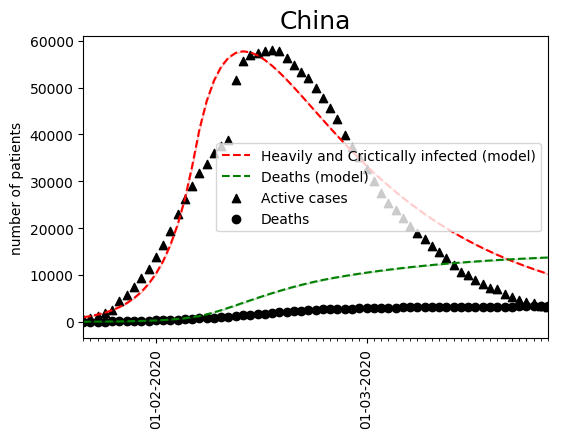

In [39]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
extraTime = estimate[1]
measureTime = estimate[2]
y0 = np.array([T0-1,1,0,0,0,0,0,0,T0])
simtime=data.size+int(extraTime)-1
tN=simtime + 1
method = 'findGovernmentResponse'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method,(extraTime,measureTime))

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index),data_china.iloc[:,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index),data_china.iloc[:,1],color="black",marker="o")
plt.plot(pd.to_datetime(index),np.mean(som,axis=1)[int(extraTime):],'--',color="red")
plt.fill_between(pd.to_datetime(index),np.percentile(som,95,axis=1)[int(extraTime):],
                 np.percentile(som,5,axis=1)[int(extraTime):],color="red",alpha=0.2)
plt.plot(pd.to_datetime(index),np.mean(D,axis=1)[int(extraTime):],'--',color="green")
plt.fill_between(pd.to_datetime(index),np.percentile(D,95,axis=1)[int(extraTime):],
                 np.percentile(D,5,axis=1)[int(extraTime):],color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('China',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Bepalen van $\beta$ voor Zuid-Korea ('Testen, testen, testen')

#### Ingeven van de data

In [4]:
columns = ['infected','dead']
infected = np.array([[19,20,20,19,42,94,190,416,578,803,944,1225,1729,2297,3109,3685,4277,5120,5498,6107,6415,6875,7097,7178,7165,7362,7293,7198,7180,7253,7024,6838,6789,6527,6325,6085,5884,5684,5410,5281,4966,4665]])
index=pd.date_range('2020-02-15', freq='D', periods=infected.size)
dead = np.array([[0,0,0,0,0,1,2,2,6,8,11,12,13,16,17,21,28,32,35,42,43,48,50,53,60,60,66,67,72,75,75,81,84,91,94,102,104,111,120,126,131,139]])
data = np.concatenate((infected,dead),axis=0)
data = np.transpose(data)
data_zuidkorea=pd.DataFrame(data,index=index, columns=columns)

#### Uitvoeren van de fit

In [12]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  51.47e06 #  Koreaanse populatie
ICU=10000

# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 200
maxiter=30
popsize=5
polish=True
disp = True
bounds=[(0.01,0.03),(1,100),(1,14)]
data=np.transpose(infected)
method = 'findGovernmentResponse'
fitTo = np.array([4,5,6])

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,T0,monteCarlo,n_samples,maxiter,popsize,polish,disp,method)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

differential_evolution step 1: f(x)= 3.20169e+08
differential_evolution step 2: f(x)= 2.04762e+08
differential_evolution step 3: f(x)= 2.04762e+08
differential_evolution step 4: f(x)= 2.04762e+08
differential_evolution step 5: f(x)= 2.04762e+08
differential_evolution step 6: f(x)= 1.26475e+08
differential_evolution step 7: f(x)= 5.56889e+07
differential_evolution step 8: f(x)= 3.24868e+07
differential_evolution step 9: f(x)= 3.24868e+07
differential_evolution step 10: f(x)= 3.21481e+07
differential_evolution step 11: f(x)= 3.1633e+07
differential_evolution step 12: f(x)= 3.13076e+07
differential_evolution step 13: f(x)= 3.11468e+07
differential_evolution step 14: f(x)= 3.10811e+07
differential_evolution step 15: f(x)= 3.10811e+07
differential_evolution step 16: f(x)= 3.10411e+07
differential_evolution step 17: f(x)= 3.10411e+07
differential_evolution step 18: f(x)= 3.10406e+07
differential_evolution step 19: f(x)= 3.10406e+07
differential_evolution step 20: f(x)= 3.10406e+07
differenti

#### Plotten van de fit

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

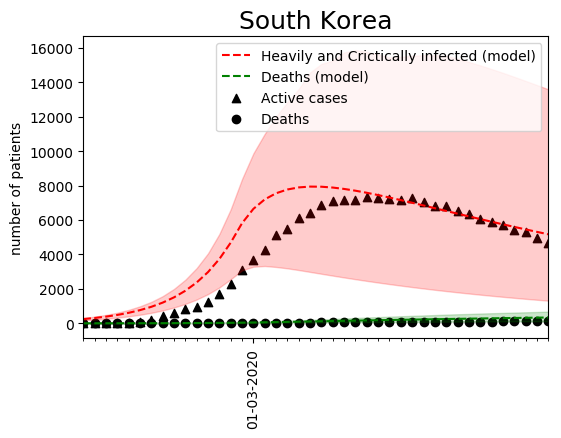

In [13]:
# ----------------
# Model parameters
# ----------------
beta = estimate[0]
extraTime = estimate[1]
measureTime = estimate[2]
y0 = np.array([T0-1,1,0,0,0,0,0,0,T0])
simtime=data.size+int(extraTime)-1
tN=simtime + 1
method = 'findGovernmentResponse'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method,(extraTime,measureTime))

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]
som = 0
for i in fitTo:
    som = som + simout[i]

# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(pd.to_datetime(index),data_zuidkorea.iloc[:,0],color="black",marker="^")
plt.scatter(pd.to_datetime(index),data_zuidkorea.iloc[:,1],color="black",marker="o")
plt.plot(pd.to_datetime(index),np.mean(som,axis=1)[int(extraTime):],'--',color="red")
plt.fill_between(pd.to_datetime(index),np.percentile(som,95,axis=1)[int(extraTime):],
                 np.percentile(som,5,axis=1)[int(extraTime):],color="red",alpha=0.2)
plt.plot(pd.to_datetime(index),np.mean(D,axis=1)[int(extraTime):],'--',color="green")
plt.fill_between(pd.to_datetime(index),np.percentile(D,95,axis=1)[int(extraTime):],
                 np.percentile(D,5,axis=1)[int(extraTime):],color="green",alpha=0.20)
plt.legend(('Heavily and Crictically infected (model)','Deaths (model)',
            'Active cases','Deaths'))

plt.xlim(pd.to_datetime(index[0]),pd.to_datetime(index[-1]))
plt.title('South Korea',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

### Conclusie

$$\beta = 0.0202,$$

wanneer de overheid drastische maatregelen oplegt. De stapsgewijze verandering van $\beta \pm 0.3$ naar $\beta \pm 0.02$ heeft een geschatte 'dode tijd' van 19 dagen. Het is belangrijk in het achterhoofd te houden dat dit een schatting is gebaseerd op de respons van HEEL CHINA, dat dit land gigantisch is en dit geen supergedetailleerd model is. Deze schatting is ruw, maar het is toch aanemelijk om deze schatting als een absolute ondergrens te gebruiken voor $\beta$ wanneer de Belgische overheid maatregelen neemt. Aangezien het onwaarschijnlijk is dat de Belgische overheid even hard kan optreden als de Chinese overheid wordt $\beta = 0.05$ als een absolute ondergrens gekozen.

## Scenario analyse voor Belgie

### 1. Geen overheidsingrijpen

In [23]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Duitse populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = True
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=300)
# Do not modify from hereon
simtime = dates.size - 1
tN = simtime + 1
period = dates.size
beta = cH.constructHorizon(beta,period)
method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

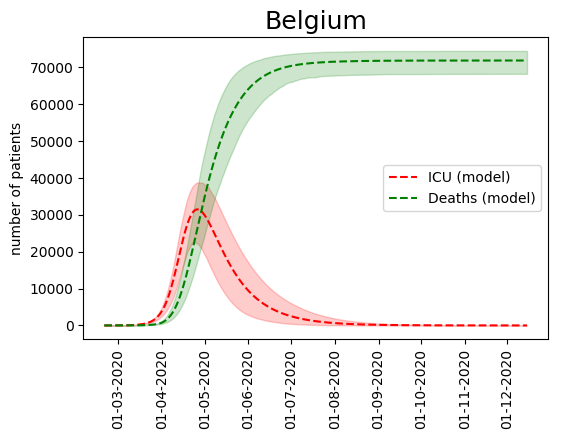

In [26]:
# ------------
# Plot results
# ------------
plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
#plt.scatter(dates,data_belgie.iloc[0:-2,0],color="black",marker="^")
#plt.scatter(dates,data_belgie.iloc[0:-2,1],color="black",marker="o")
plt.plot(dates,np.mean(H,axis=1),'--',color="red")
plt.fill_between(dates,np.percentile(H,95,axis=1),
                 np.percentile(H,5,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(D,axis=1),'--',color="green")
plt.fill_between(dates,np.percentile(D,95,axis=1),
                 np.percentile(D,5,axis=1),color="green",alpha=0.20)
plt.legend(('ICU (model)','Deaths (model)'))

#plt.xlim(dates,pd.to_datetime(index[-1]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<Figure size 432x288 with 0 Axes>

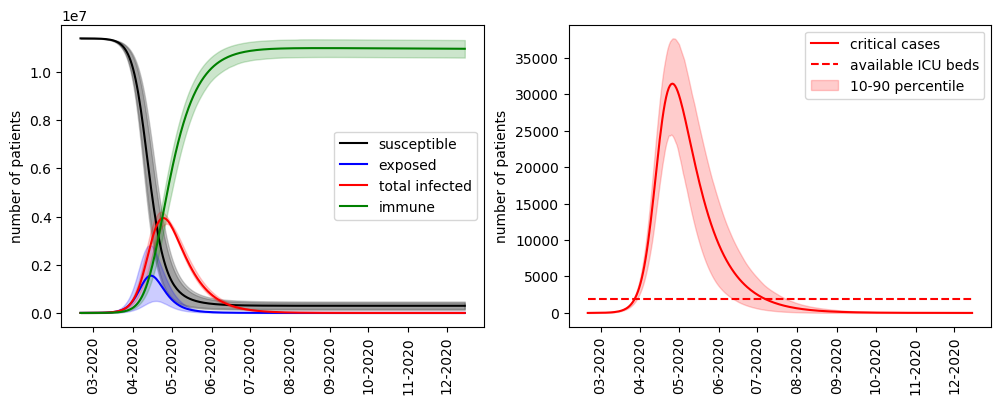

In [28]:
plt.figure(1)
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(1, 2, 1)

som = SM+M+Z+H
plt.plot(dates,np.mean(O,axis=1),color="black")
plt.fill_between(dates, np.mean(O,axis=1)-np.std(O,axis=1), np.mean(O,axis=1)+np.std(O,axis=1),color="black",alpha=0.2)
plt.fill_between(dates, np.percentile(O,90,axis=1), np.percentile(O,10,axis=1),color="black",alpha=0.2)
plt.plot(dates,np.mean(B,axis=1),color="blue")
plt.fill_between(dates, np.percentile(B,90,axis=1), np.percentile(B,10,axis=1),color="blue",alpha=0.2)
plt.plot(dates,np.mean(som,axis=1),color="red")
plt.fill_between(dates, np.percentile(som,90,axis=1), np.percentile(som,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(I,axis=1),color="green")
plt.fill_between(dates, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="green",alpha=0.2)

#plt.title('China',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)
plt.ylabel('number of patients')
plt.legend(('susceptible', 'exposed','total infected', 'immune'))
plt.ylabel("number of patients")

plt.subplot(1, 2, 2)
plt.plot(dates,np.mean(H,axis=1),color="red")
plt.fill_between(dates, np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.ones([tN])*1900,'--',color="red")
plt.legend(('critical cases', 'available ICU beds','10-90 percentile'))
plt.ylabel("number of patients")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

### 2. Lockdown tot 3 april, daarna halve maatregelen

In [63]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Duitse populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = True
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=300)
# Calculate simulation time
simtime = dates.size - 1
tN = simtime + 1
# Manual construction of beta
beta = np.ones([tN])
beta = 0.222*beta
beta[0:24]=0.222 # data begint op 20 februari, eerst actie overheid op vrijdag 13 maart (dag 21)
beta[24:27]=0.20 # overheid neemt 'halve maatregelen' gedurende het weekend (vrijdag 13/03 --> maandag 16/03)
beta[27:27+35]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (18 dagen)
method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<Figure size 432x288 with 0 Axes>

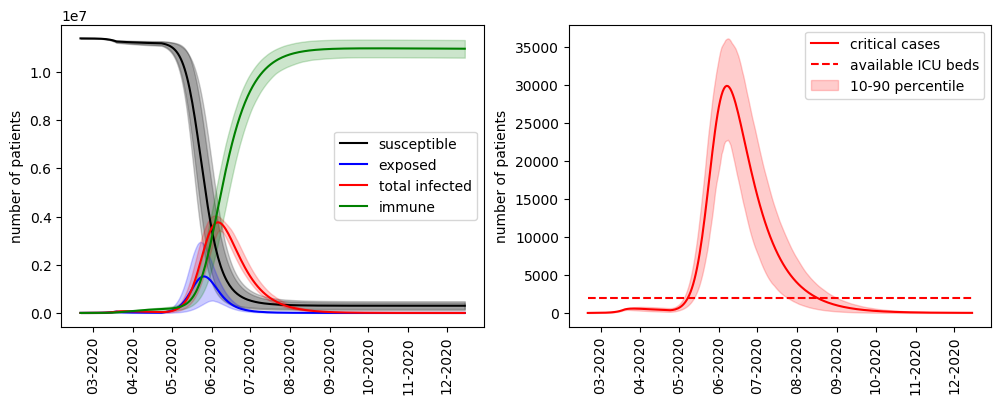

In [64]:
plt.figure(1)
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(1, 2, 1)

som = SM+M+Z+H
plt.plot(dates,np.mean(O,axis=1),color="black")
plt.fill_between(dates, np.mean(O,axis=1)-np.std(O,axis=1), np.mean(O,axis=1)+np.std(O,axis=1),color="black",alpha=0.2)
plt.fill_between(dates, np.percentile(O,90,axis=1), np.percentile(O,10,axis=1),color="black",alpha=0.2)
plt.plot(dates,np.mean(B,axis=1),color="blue")
plt.fill_between(dates, np.percentile(B,90,axis=1), np.percentile(B,10,axis=1),color="blue",alpha=0.2)
plt.plot(dates,np.mean(som,axis=1),color="red")
plt.fill_between(dates, np.percentile(som,90,axis=1), np.percentile(som,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(I,axis=1),color="green")
plt.fill_between(dates, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="green",alpha=0.2)

#plt.title('China',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)
plt.ylabel('number of patients')
plt.legend(('susceptible', 'exposed','total infected', 'immune'))
plt.ylabel("number of patients")

plt.subplot(1, 2, 2)
plt.plot(dates,np.mean(H,axis=1),color="red")
plt.fill_between(dates, np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.ones([tN])*1900,'--',color="red")

plt.legend(('critical cases', 'available ICU beds','10-90 percentile'))
plt.ylabel("number of patients")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

300


[None, None, None, None, None, None]

<Figure size 432x288 with 0 Axes>

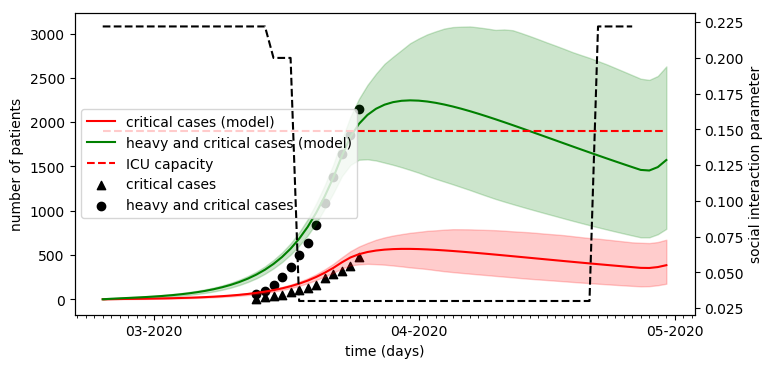

In [65]:
plt.figure(1)
plt.figure(figsize=(8,4),dpi=100)
plt.plot(dates[0:67]+datetime.timedelta(days=4),np.mean(H,axis=1)[0:67],color="red")
plt.plot(dates[0:67]+datetime.timedelta(days=4),np.mean(Z,axis=1)[0:67]+np.mean(H,axis=1)[0:67],color="green")
plt.plot(dates[0:67]+datetime.timedelta(days=4),np.ones([67])*1900,'--',color="red")

ICU=np.array([5,24,33,53,79,100,130,164,238,290,322,381,474])
opgenomen = np.array([58,97,163,252,361,496,634,837,1089,1380,1643,1859,2152])
t=pd.date_range('2020-03-13', freq='D', periods=ICU.size)

plt.scatter(t,ICU,marker='^',color='black')
plt.scatter(t,opgenomen,marker='o',color='black')
plt.fill_between(dates[0:67]+datetime.timedelta(days=4), np.percentile(H,90,axis=1)[0:67], np.percentile(H,10,axis=1)[0:67],color="red",alpha=0.2)
s = Z+H
plt.fill_between(dates[0:67]+datetime.timedelta(days=4),np.percentile(s,90,axis=1)[0:67], np.percentile(s,10,axis=1)[0:67],color="green",alpha=0.2)

plt.legend(('critical cases (model)', 'heavy and critical cases (model)','ICU capacity','critical cases','heavy and critical cases'),loc='center left')
#plt.xlim(dates[0],dates[-1])
print(beta.size)
plt.ylabel("number of patients")
plt.xlabel("time (days)")
ax2 = plt.twinx()
ax2.plot(dates[4:67],beta[4:67],"--",color="black")
ax2.set_ylabel("social interaction parameter")

plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)


### 3. Sociale regeling naar groepsimmuniteit

#### 3.1 Aan -uitregelaar met intervallen van 1 maand voor 12 maanden

In [53]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Belgische populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = True
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=2*365)
# Calculate simulation time
simtime = dates.size - 1
tN = simtime + 1
# Manual construction of beta
beta = np.ones([tN])
beta = 0.222*beta
# reeds beslist: plaatsgevonden
beta[0:24]=0.222 # data begint op 20 februari, eerst actie overheid op vrijdag 13 maart (dag 21)
beta[24:27]=0.20 # overheid neemt 'halve maatregelen' gedurende het weekend (vrijdag 13/03 --> maandag 16/03)
beta[27:27+35]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
# alternerend aan/uit
beta[27+35:27+35+30]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+30:27+35+60]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+60:27+35+90]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+90:27+35+120]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+120:27+35+150]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+150:27+35+180]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+180:27+35+210]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+210:27+35+240]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+240:27+35+270]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+270:27+35+300]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+300:27+35+330]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+330:27+35+360]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]

Text(0, 0.5, 'social interaction parameter')

<Figure size 432x288 with 0 Axes>

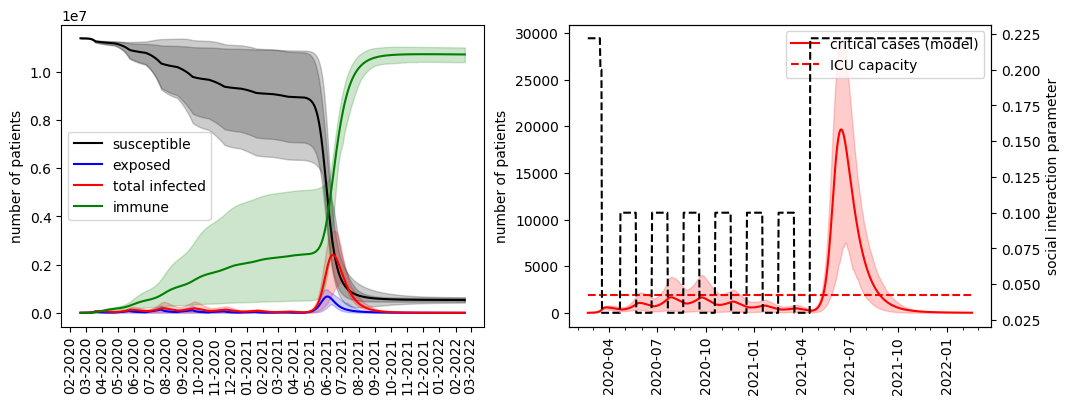

In [54]:
plt.figure(1)
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(1, 2, 1)
som = SM+M+Z+H
plt.plot(dates,np.mean(O,axis=1),color="black")
plt.fill_between(dates, np.mean(O,axis=1)-np.std(O,axis=1), np.mean(O,axis=1)+np.std(O,axis=1),color="black",alpha=0.2)
plt.fill_between(dates, np.percentile(O,90,axis=1), np.percentile(O,10,axis=1),color="black",alpha=0.2)
plt.plot(dates,np.mean(B,axis=1),color="blue")
plt.fill_between(dates, np.percentile(B,90,axis=1), np.percentile(B,10,axis=1),color="blue",alpha=0.2)
plt.plot(dates,np.mean(som,axis=1),color="red")
plt.fill_between(dates, np.percentile(som,90,axis=1), np.percentile(som,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(I,axis=1),color="green")
plt.fill_between(dates, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="green",alpha=0.2)

#plt.title('China',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)
plt.ylabel('number of patients')
plt.legend(('susceptible', 'exposed','total infected', 'immune'))
plt.ylabel("number of patients")

plt.subplot(1, 2, 2)
plt.plot(dates,np.mean(H,axis=1),color="red")
#plt.plot(dates,np.mean(Z,axis=1)+np.mean(H,axis=1),color="green")
#plt.fill_between(dates, np.percentile(H+Z,90,axis=1), np.percentile(H+Z,10,axis=1),color="green",alpha=0.2)

plt.plot(dates,np.ones([tN])*1900,'--',color="red")

plt.fill_between(dates, np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.legend(('critical cases (model)','ICU capacity'))

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

plt.ylabel("number of patients")
ax2 = plt.twinx()
ax2.plot(dates,beta,"--",color="black")
ax2.set_ylabel("social interaction parameter")

In [57]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Belgische populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = True
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=4*365)
# Calculate simulation time
simtime = dates.size - 1
tN = simtime + 1
# Manual construction of beta
beta = np.ones([tN])
beta = 0.222*beta
# reeds beslist: plaatsgevonden
beta[0:24]=0.222 # data begint op 20 februari, eerst actie overheid op vrijdag 13 maart (dag 21)
beta[24:27]=0.20 # overheid neemt 'halve maatregelen' gedurende het weekend (vrijdag 13/03 --> maandag 16/03)
beta[27:27+35]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
# alternerend aan/uit
# toekomst:
beta[27+35:27+35]=0.03 # zware maatregelen blijven duren tot paasmaandag 19/04
beta[27+35:27+35+30]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+30:27+35+60]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+60:27+35+90]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+90:27+35+120]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+120:27+35+150]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+150:27+35+180]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+180:27+35+210]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+210:27+35+240]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+240:27+35+270]=0.10 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+270:27+35+300]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+300:27+35+330]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+330:27+35+360]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+360:27+35+390]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+390:27+35+420]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+420:27+35+450]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+450:27+35+480]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+480:27+35+520]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+520:27+35+550]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+550:27+35+580]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+580:27+35+610]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+610:27+35+640]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+640:27+35+670]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+670:27+35+700]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+700:27+35+730]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+730:27+35+760]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+760:27+35+790]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+790:27+35+820]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+820:27+35+850]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+850:27+35+880]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+880:27+35+910]=0.20 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+910:27+35+940]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+940:27+35+970]=0.244 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+970:27+35+1000]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+1000:27+35+1030]=0.244 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)
beta[27+35+1030:27+35+1060]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (19 dagen)

method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]

Text(0, 0.5, 'social interaction parameter')

<Figure size 432x288 with 0 Axes>

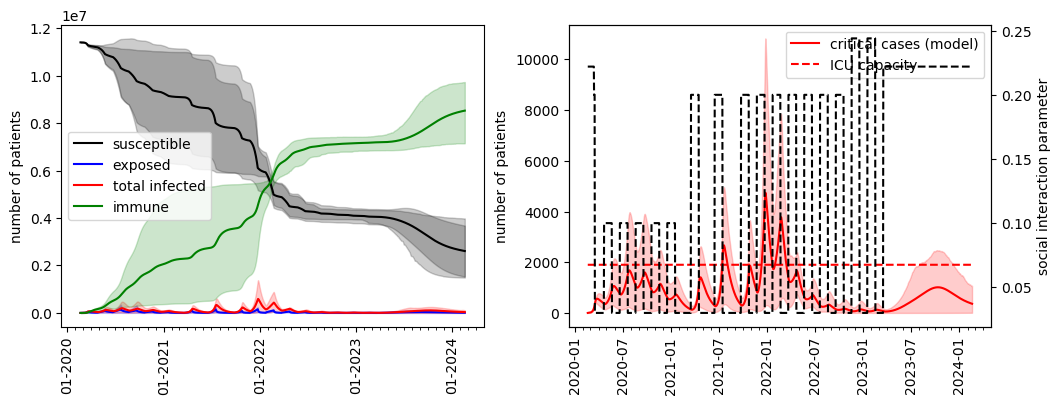

In [58]:
plt.figure(1)
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(1, 2, 1)
som = SM+M+Z+H
plt.plot(dates,np.mean(O,axis=1),color="black")
plt.fill_between(dates, np.mean(O,axis=1)-np.std(O,axis=1), np.mean(O,axis=1)+np.std(O,axis=1),color="black",alpha=0.2)
plt.fill_between(dates, np.percentile(O,90,axis=1), np.percentile(O,10,axis=1),color="black",alpha=0.2)
plt.plot(dates,np.mean(B,axis=1),color="blue")
plt.fill_between(dates, np.percentile(B,90,axis=1), np.percentile(B,10,axis=1),color="blue",alpha=0.2)
plt.plot(dates,np.mean(som,axis=1),color="red")
plt.fill_between(dates, np.percentile(som,90,axis=1), np.percentile(som,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(I,axis=1),color="green")
plt.fill_between(dates, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="green",alpha=0.2)

#plt.title('China',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)
plt.ylabel('number of patients')
plt.legend(('susceptible', 'exposed','total infected', 'immune'))
plt.ylabel("number of patients")

plt.subplot(1, 2, 2)
plt.plot(dates,np.mean(H,axis=1),color="red")
#plt.plot(dates,np.mean(Z,axis=1)+np.mean(H,axis=1),color="green")
#plt.fill_between(dates, np.percentile(H+Z,90,axis=1), np.percentile(H+Z,10,axis=1),color="green",alpha=0.2)

plt.plot(dates,np.ones([tN])*1900,'--',color="red")

plt.fill_between(dates, np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.legend(('critical cases (model)','ICU capacity'))

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

plt.ylabel("number of patients")
ax2 = plt.twinx()
ax2.plot(dates,beta,"--",color="black")
ax2.set_ylabel("social interaction parameter")

### Model Predictive control

#### Initiele conditie voor regelaar is de toestand op 19/04

In [22]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Belgische populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = False
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=27+35)
# Calculate simulation time
simtime = dates.size - 1
tN = simtime + 1
# Manual construction of policy vector
beta = np.ones([tN])
beta = 0.222*beta
beta[0:24]=0.222 # data begint op 20 februari, eerst actie overheid op vrijdag 13 maart (dag 21)
beta[24:27]=0.20 # overheid neemt 'halve maatregelen' gedurende het weekend (vrijdag 13/03 --> maandag 16/03)
beta[27:27+35]=0.03 # zware maatregelen van kracht van maandag 16/03 tot vrijdag 03/04 (18 dagen)
# Simulation method
method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]


# ---------------------------------------------------------------------------
# Calculate predicted initial condition under current policy (starting 19/04)
# ---------------------------------------------------------------------------
O = np.mean(O,axis=1)
B = np.mean(B,axis=1)
SM = np.mean(SM,axis=1)
M = np.mean(M,axis=1)
Z = np.mean(Z,axis=1)
H = np.mean(H,axis=1)
I = np.mean(I,axis=1)
D = np.mean(D,axis=1)
T = np.mean(T,axis=1)
y0 = np.array([O[-1],B[-1],SM[-1],M[-1],Z[-1],H[-1],I[-1],D[-1],T[-1]])

#### Regelaar configureren

In [23]:
# algemene parameters
period = 7
nPeriods = 1
P = 18 # 12
N = 6 # 3
roundOff=(0.2439,0.1999,0.04)
discrete = False
monteCarlo = False

# parameters weging doelfunctie
Kh = 1 # 100
Kd = 0 # 0
Ki = 0 # 0.001

# parameters optimalisatie
maxiter=300
popsize=50
polish=True
disp = True

#### Optimalisatie over gekozen predictiehorizon startende vanaf 19/04

In [10]:
beta = cH.MPCoptimize(y0,nat,mort,dSM,dM,dZ,m,z,h,mh,ICU,monteCarlo,n_samples,period,maxiter,popsize,polish,disp,P,N,discrete,roundOff,Kh,Kd,Ki)

differential_evolution step 1: f(x)= 3.85289e+07
differential_evolution step 2: f(x)= 3.85289e+07
differential_evolution step 3: f(x)= 2.95269e+07
differential_evolution step 4: f(x)= 2.85795e+07
differential_evolution step 5: f(x)= 2.85795e+07
differential_evolution step 6: f(x)= 2.85795e+07
differential_evolution step 7: f(x)= 2.66851e+07
differential_evolution step 8: f(x)= 2.66851e+07
differential_evolution step 9: f(x)= 2.66851e+07
differential_evolution step 10: f(x)= 2.40315e+07
differential_evolution step 11: f(x)= 2.40315e+07
differential_evolution step 12: f(x)= 2.36518e+07
differential_evolution step 13: f(x)= 2.18901e+07
differential_evolution step 14: f(x)= 2.18901e+07
differential_evolution step 15: f(x)= 2.18901e+07
differential_evolution step 16: f(x)= 2.18901e+07
differential_evolution step 17: f(x)= 2.18901e+07
differential_evolution step 18: f(x)= 2.18901e+07
differential_evolution step 19: f(x)= 2.18901e+07
differential_evolution step 20: f(x)= 2.16271e+07
different

differential_evolution step 165: f(x)= 2.04349e+07
differential_evolution step 166: f(x)= 2.04349e+07
differential_evolution step 167: f(x)= 2.04349e+07
differential_evolution step 168: f(x)= 2.04349e+07
differential_evolution step 169: f(x)= 2.04349e+07
differential_evolution step 170: f(x)= 2.04349e+07
differential_evolution step 171: f(x)= 2.04349e+07
differential_evolution step 172: f(x)= 2.04349e+07
differential_evolution step 173: f(x)= 2.04349e+07
differential_evolution step 174: f(x)= 2.04349e+07
differential_evolution step 175: f(x)= 2.04349e+07
differential_evolution step 176: f(x)= 2.04349e+07
differential_evolution step 177: f(x)= 2.04349e+07
differential_evolution step 178: f(x)= 2.04349e+07
differential_evolution step 179: f(x)= 2.04349e+07
differential_evolution step 180: f(x)= 2.04349e+07
differential_evolution step 181: f(x)= 2.04349e+07
differential_evolution step 182: f(x)= 2.04349e+07
differential_evolution step 183: f(x)= 2.04349e+07
differential_evolution step 184

#### Visualisatie voorspelde policy

In [24]:
beta = np.array([0.244,0.14176951,0.03,0.03544119,0.04912096,0.06033642])
# construct horizon from 19/04 onwards
betastar = cH.constructHorizon(np.asarray(beta),period)

In [25]:
# ----------------
# Model parameters
# ----------------
# gamma, dHD, dHI and sm are hardcoded in the function 'modelFit'
nat = 9.9/1000/365 # nataliteit Vlaanderen 2018 (per dag)
mort = 9.6/1000/365 # mortaliteit Vlaanderen 2018 (per dag)
dSM = 14 # duur ziekte bij supermild verloop
dM = 14 # duur ziekte bij mild verloop
dZ = 21 # duur ziekte bij zwaar veroop
m = (1-sm)*0.81 # kans op mild ziekteverloop
z = (1-sm)*0.14 # kans op zwaar ziekteverloop
h = (1-sm)*0.05 # kans op hevig ziekteverloop (Intensive care unit)
mh = 0.49 # mortaliteit bij hevig verloop
T0 =  11.4e06 # Belgische populatie
ICU = 1900

# ---------------------
# Simulation parameters
# ---------------------
# Initial condition and estimates
beta = 0.222
B0 = 673
y0 = np.array([T0-B0,B0,0,0,0,0,0,0,T0])
# Monte Carlo sampling
monteCarlo = False
n_samples = 500
# Modify 'dates'
dates=pd.date_range('2020-02-20', freq='D', periods=27+35+betastar.size)
# Calculate simulation time
simtime = dates.size - 1
tN = simtime + 1
# Manual construction of policy vector
beta = np.ones([tN])
beta = 0.222*beta
beta[0:24]=0.222 # data begint op 20 februari, eerst actie overheid op vrijdag 13 maart (dag 21)
beta[24:27]=0.20 # overheid neemt 'halve maatregelen' gedurende het weekend (vrijdag 13/03 --> maandag 16/03)
beta[27:27+35]=0.03 # zware maatregelen van kracht van maandag 16/03 tot 19/04 (35 dagen)
# ADD: extend beta with MBPR prediction
beta[27+35:27+35+betastar.size-1] = betastar[1:]
# Simulation method
method = 'variableBeta'

# --------------
# Run simulation
# --------------
simout = cH.simModel(y0,nat,mort,beta,dSM,dM,dZ,m,z,h,mh,ICU,tN,simtime,monteCarlo,n_samples,method)

# ---------------
# Extract results
# ---------------
t = simout[0]
O = simout[1]
B = simout[2]
SM = simout[3]
M = simout[4]
Z = simout[5]
H = simout[6]
I = simout[7]
D = simout[8]
T = simout[9]

Text(0, 0.5, 'social interaction parameter')

<Figure size 432x288 with 0 Axes>

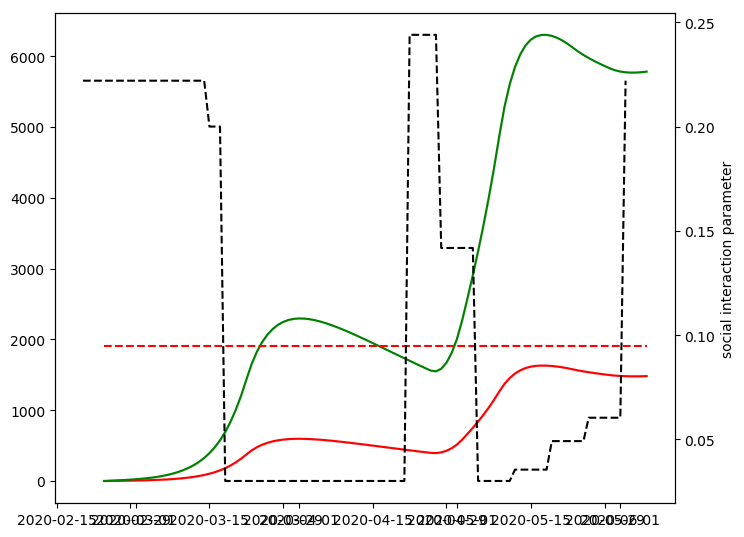

In [26]:
plt.figure()
plt.figure(figsize=(8,6.5),dpi=100)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
# #plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

# plt.setp(plt.gca().xaxis.get_majorticklabels(),
#           'rotation', 90)
plt.plot(dates+datetime.timedelta(days=4),np.mean(H,axis=1),color="red")
plt.fill_between(dates+datetime.timedelta(days=4), np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.plot(dates+datetime.timedelta(days=4),np.mean(Z,axis=1)+np.mean(H,axis=1),color="green")
plt.fill_between(dates+datetime.timedelta(days=4), np.percentile(H+Z,90,axis=1), np.percentile(H+Z,10,axis=1),color="green",alpha=0.2)
plt.plot(dates+datetime.timedelta(days=4),np.ones([tN])*1900,'--',color="red")

# ICU=np.array([5,24,33,53,79,100,130,164,238,290,322,381,474])
# opgenomen = np.array([58,97,163,252,361,496,634,837,1089,1380,1643,1859,2152])
# t=pd.date_range('2020-03-13', freq='D', periods=ICU.size)

ax2 = plt.twinx()
#ax2.plot(dates+datetime.timedelta(days=4),np.append(beta[4:],np.array([beta[-1],beta[-1],beta[-1],beta[-1],])),"--",color="black")
ax2.plot(dates,beta,"--",color="black")
ax2.set_ylabel("social interaction parameter")
#plt.xticks([dates[0]])

Text(0, 0.5, 'social interaction parameter')

<Figure size 432x288 with 0 Axes>

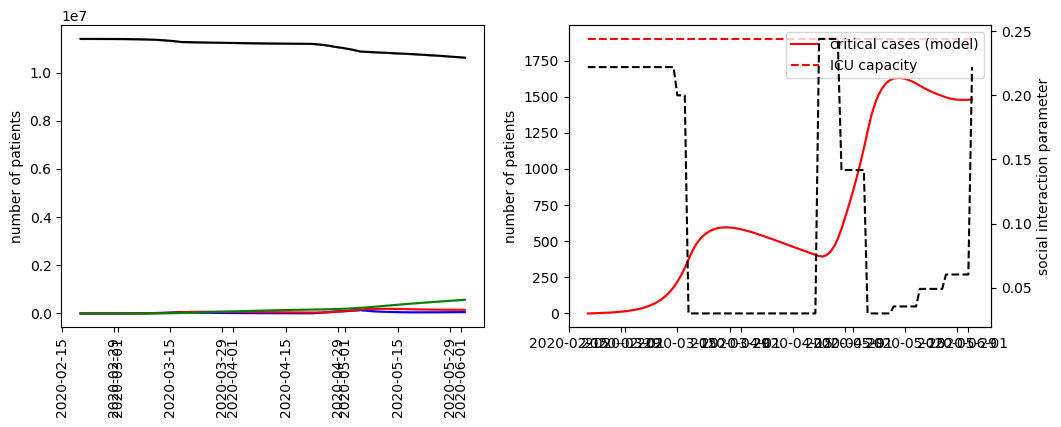

In [28]:
plt.figure(10)
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(1, 2, 1)
som = SM+M+Z+H
plt.plot(dates,np.mean(O,axis=1),color="black")
plt.fill_between(dates, np.mean(O,axis=1)-np.std(O,axis=1), np.mean(O,axis=1)+np.std(O,axis=1),color="black",alpha=0.2)
plt.fill_between(dates, np.percentile(O,90,axis=1), np.percentile(O,10,axis=1),color="black",alpha=0.2)
plt.plot(dates,np.mean(B,axis=1),color="blue")
plt.fill_between(dates, np.percentile(B,90,axis=1), np.percentile(B,10,axis=1),color="blue",alpha=0.2)
plt.plot(dates,np.mean(som,axis=1),color="red")
plt.fill_between(dates, np.percentile(som,90,axis=1), np.percentile(som,10,axis=1),color="red",alpha=0.2)
plt.plot(dates,np.mean(I,axis=1),color="green")
plt.fill_between(dates, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="green",alpha=0.2)

#plt.title('China',{'fontsize':18})
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)
plt.ylabel('number of patients')
#plt.legend(('susceptible', 'exposed','total infected', 'immune'))
#plt.ylabel("number of patients")



plt.subplot(1, 2, 2)
plt.plot(dates,np.mean(H,axis=1),color="red")
#plt.plot(dates,np.mean(Z,axis=1)+np.mean(H,axis=1),color="green")
#plt.fill_between(dates, np.percentile(H+Z,90,axis=1), np.percentile(H+Z,10,axis=1),color="green",alpha=0.2)

plt.plot(dates,np.ones([tN])*1900,'--',color="red")

plt.fill_between(dates, np.percentile(H,90,axis=1), np.percentile(H,10,axis=1),color="red",alpha=0.2)
plt.legend(('critical cases (model)','ICU capacity'),loc='upper right')

#plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
#plt.setp(plt.gca().xaxis.get_majorticklabels(),
#          'rotation', 90)

plt.ylabel("number of patients")
ax2 = plt.twinx()
ax2.plot(dates,beta,"--",color="black")
ax2.set_ylabel("social interaction parameter")